In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from google.colab import files
import io

In [ ]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['JNJ.csv']))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Saving JNJ.csv to JNJ.csv


In [ ]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=14).mean() / df['Close'].diff().apply(lambda x: -x if x < 0 else 0).rolling(window=14).mean()))
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df.fillna(method='bfill', inplace=True)

In [ ]:
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI', 'OBV']].values
features = np.nan_to_num(features)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 3])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, sequence_length)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for train_index, val_index in kf.split(X):
    train_X, val_X = X[train_index], X[val_index]
    train_y, val_y = y[train_index], y[val_index]

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
        Dropout(0.2),
        BatchNormalization(),
        LSTM(50, kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(val_X, val_y), verbose=1, callbacks=[early_stopping, reduce_lr])

    val_loss = model.evaluate(val_X, val_y, verbose=0)
    results.append(val_loss)

Epoch 1/50
391/391 [==============================] - 42s 91ms/step - loss: 0.3680 - val_loss: 0.0833 - lr: 5.0000e-04
Epoch 2/50
391/391 [==============================] - 31s 80ms/step - loss: 0.1784 - val_loss: 0.0650 - lr: 5.0000e-04
Epoch 3/50
391/391 [==============================] - 32s 81ms/step - loss: 0.1047 - val_loss: 0.0529 - lr: 5.0000e-04
Epoch 4/50
391/391 [==============================] - 31s 80ms/step - loss: 0.0672 - val_loss: 0.0429 - lr: 5.0000e-04
Epoch 5/50
391/391 [==============================] - 34s 88ms/step - loss: 0.0476 - val_loss: 0.0342 - lr: 5.0000e-04
Epoch 6/50
391/391 [==============================] - 31s 80ms/step - loss: 0.0357 - val_loss: 0.0266 - lr: 5.0000e-04
Epoch 7/50
391/391 [==============================] - 30s 77ms/step - loss: 0.0274 - val_loss: 0.0207 - lr: 5.0000e-04
Epoch 8/50
391/391 [==============================] - 31s 79ms/step - loss: 0.0214 - val_loss: 0.0157 - lr: 5.0000e-04
Epoch 9/50
391/391 [============================

In [ ]:
average_val_loss = np.mean(results)
print(f'Average Validation Loss: {average_val_loss}')

Average Validation Loss: 9.39228106290102e-05


In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
440/440 [==============================] - 40s 76ms/step - loss: 0.4006 - val_loss: 0.1183 - lr: 5.0000e-04
Epoch 2/50
440/440 [==============================] - 32s 73ms/step - loss: 0.1771 - val_loss: 0.0659 - lr: 5.0000e-04
Epoch 3/50
440/440 [==============================] - 34s 77ms/step - loss: 0.0975 - val_loss: 0.0572 - lr: 5.0000e-04
Epoch 4/50
440/440 [==============================] - 31s 71ms/step - loss: 0.0608 - val_loss: 0.0529 - lr: 5.0000e-04
Epoch 5/50
440/440 [==============================] - 32s 72ms/step - loss: 0.0418 - val_loss: 0.0489 - lr: 5.0000e-04
Epoch 6/50
440/440 [==============================] - 32s 73ms/step - loss: 0.0313 - val_loss: 0.0382 - lr: 5.0000e-04
Epoch 7/50
440/440 [==============================] - 34s 76ms/step - loss: 0.0236 - val_loss: 0.0339 - lr: 5.0000e-04
Epoch 8/50
440/440 [==============================] - 32s 74ms/step - loss: 0.0179 - val_loss: 0.0187 - lr: 5.0000e-04
Epoch 9/50
440/440 [============================

In [ ]:
predicted_prices = model.predict(X)
predicted_prices_extended = np.zeros((predicted_prices.shape[0], scaled_features.shape[1]))
predicted_prices_extended[:, 3] = predicted_prices[:, 0]
predicted_prices = scaler.inverse_transform(predicted_prices_extended)[:, 3]


489/489 [==============================] - 11s 21ms/step


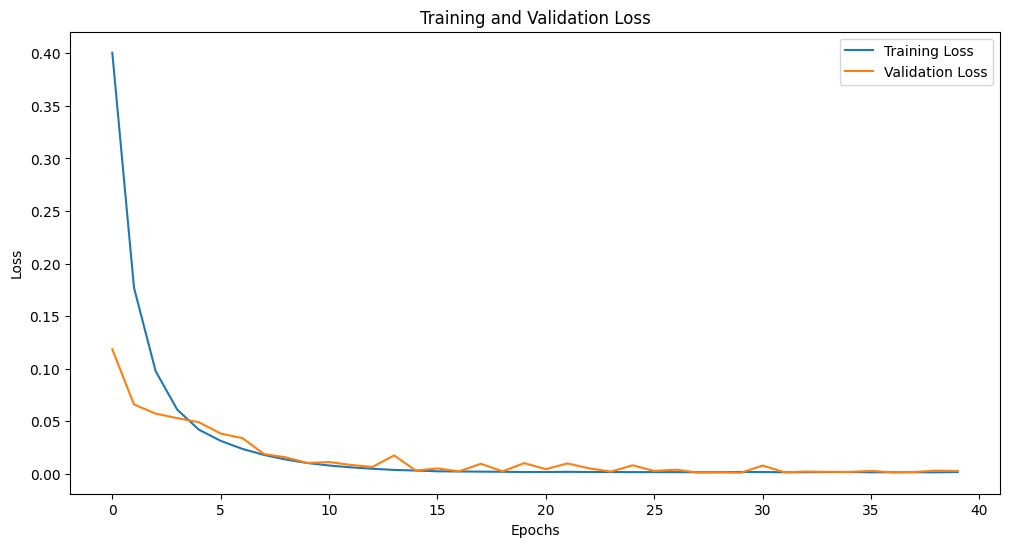

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

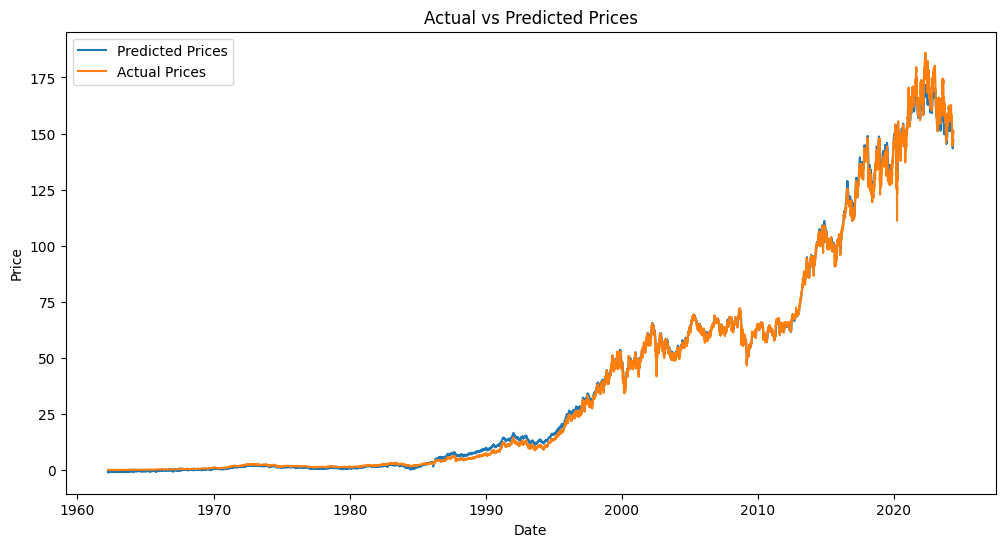

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[sequence_length:], predicted_prices, label='Predicted Prices')
plt.plot(df.index[sequence_length:], df['Close'].values[sequence_length:], label='Actual Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()